## Task planning & Goal: 
### Metrics/hypothesis for generating data insights
###### 1. Customer 
- LTV, Conversion, retention, customer turnover, New Customer acquisition
- <strong>RFM</strong> to measure customer's frequency and purchase power, and recency to compare to recently date
- Cohort model: Customer churn, repurchase rate to measure "stickness"(retention) + loyalty/-purchase behaviors of customer 
- is discount promotion increase sales or new customers acquisition(H0)

###### 2. Product: 4P rule
- Products-> Pricing -> Place(online, if Omi-channel?-> offline: demographic city/region)

###### 3. ML
- Timeseries analysis: Sales and Profits (KPI)
- Sales target(model: linear regression)
- Anomaly detetcion: For e-commerce there are always some fake purchases(TBC)
- Cluserting (TBC)

### Workflow
- Data processing for cleaning and aggregation
- Date modeling: build demo-size Database (MySQL)
- Load data to DB 
- Connect DB with Apache Superset and deploy dashboard on AWS
- Build dashboard with Tableau (Optional) 
- Predictive analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
import datetime as dt
import sys
import os 

# build helper functions
FILE_PATH= "../data/Data Analyst Case Chaoly.xlsx"
def get_data(base_file: str, tab_nb: int, order_date: str=None, ship_date: str=None)-> pd.DataFrame:
    return pd.read_excel(base_file,
                         tab_nb,
                        parse_date = ["order_date","ship_date"],
                        infer_datetime_format = True)

In [2]:
# read dataset
ListOfOrders = get_data(FILE_PATH, 0, "Order Date", "Ship Date")
OrderBreakdown = get_data(FILE_PATH, 1)
SalesTargets = get_data(FILE_PATH, 2)

#### Separate datasets and save as csv format

In [3]:
PROCESSED_PATH = "../processedData/"
listoforders = "ListOfOrders.csv"
orderbreakdown = "OrderBreakdown.csv"
salestargets = "SalesTargets.csv" 

ListOfOrders.to_csv(os.path.join(PROCESSED_PATH, listoforders), index= False)
OrderBreakdown.to_csv(os.path.join(PROCESSED_PATH, orderbreakdown), index= False)
SalesTargets.to_csv(os.path.join(PROCESSED_PATH, salestargets), index= False) 

#### Load raw data (fact table) to MySQL database

In [4]:
USER= "root"
PSWD= "password"
DB= "ecommerceTask"

In [5]:
sys.path.append("../scripts")
from connect_sql import load_data

load_data(USER, PSWD, DB, "listoforders", ListOfOrders_path)
load_data(USER, PSWD, DB, "orderbreakdown", OrderBreakdown_path)
load_data(USER, PSWD, DB, "salestargets", SalesTargets_path)

#### EDA, data preprocessing 
- check is any Null values, if then dropna

- check row-wise duplicated -> remove 

In [6]:
def isnull(df):
    return df.isnull().sum()

def isna(df):
    return df.isna().sum()

In [7]:
isnull(ListOfOrders)

Order ID         0
Order Date       0
Customer Name    0
City             0
Country          0
Region           0
Segment          0
Ship Date        0
Ship Mode        0
State            0
dtype: int64

In [8]:
isna(ListOfOrders) 

Order ID         0
Order Date       0
Customer Name    0
City             0
Country          0
Region           0
Segment          0
Ship Date        0
Ship Mode        0
State            0
dtype: int64

In [9]:
isnull(OrderBreakdown)
isnull(SalesTargets) 

Month of Order Date    0
Category               0
Target                 0
dtype: int64

In [10]:
ListOfOrders.duplicated().any() 

False

In [11]:
OrderBreakdown.duplicated().any()
# OrderBreakdown.columns

True

In [12]:
SalesTargets.duplicated().any() 

False

In [13]:
ListOfOrders.tail(2) 
# ListOfOrders[ListOfOrders["Order ID"]=="BN-2014-4140795"] 

,Order ID,Order Date,Customer Name,City,Country,Region,Segment,Ship Date,Ship Mode,State
4115,AZ-2014-7604524,2014-12-31,Rebecca Chamberlain,Hamburg,Germany,Central,Home Office,2015-01-04,Economy,Hamburg
4116,BN-2014-4140795,2014-12-31,Daniel Hamilton,Eindhoven,Netherlands,Central,Home Office,2015-01-05,Economy Plus,North Brabant


In [14]:
OrderBreakdown.head(2)
# OrderBreakdown[OrderBreakdown["Order ID"]=="BN-2014-4140795"] 

,Order ID,Product Name,Discount,Sales,Profit,Quantity,Category,Sub-Category
0,BN-2011-7407039,"Enermax Note Cards, Premium",0.5,45,-26,3,Office Supplies,Paper
1,AZ-2011-9050313,"Dania Corner Shelving, Traditional",0.0,854,290,7,Furniture,Bookcases


In [15]:
# For each main category => sub-category, monthly sales target below. 
SalesTargets.head(2) 

,Month of Order Date,Category,Target
0,2011-01-01,Furniture,10000
1,2011-02-01,Furniture,10100


In [16]:
SalesTargets.Category.unique() 

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [17]:
# => expand order list
FullOrderList= ListOfOrders.merge(OrderBreakdown, on="Order ID", how="left")
FullOrderList.tail(2)

,Order ID,Order Date,Customer Name,City,Country,Region,Segment,Ship Date,Ship Mode,State,Product Name,Discount,Sales,Profit,Quantity,Category,Sub-Category
8045,BN-2014-4140795,2014-12-31,Daniel Hamilton,Eindhoven,Netherlands,Central,Home Office,2015-01-05,Economy Plus,North Brabant,"Avery Binder Covers, Recycled",0.5,23,-6,4,Office Supplies,Binders
8046,BN-2014-4140795,2014-12-31,Daniel Hamilton,Eindhoven,Netherlands,Central,Home Office,2015-01-05,Economy Plus,North Brabant,"StarTech Phone, Red",0.5,108,-19,3,Technology,Machines


In [18]:
FullOrderList.groupby(["Order Date", "City"])["Sales"].sum().sort_values(ascending= False)  

Order Date  City        
2012-08-24  Bochum          7630
2014-11-12  Villach         7382
2012-12-13  Huddersfield    7048
2011-09-08  Lugo            6974
2013-02-27  Edinburgh       6703
                            ... 
2012-08-15  Zeist              7
2014-02-04  Zwolle             6
2014-02-27  Wasquehal          5
2013-11-28  Osny               5
2012-06-29  Solna              3
Name: Sales, Length: 4090, dtype: int64

In [19]:
FullOrderList.to_csv(os.path.join(PROCESSED_PATH, "fullorderlist.csv"), index= False)

In [20]:
OrderLists= FullOrderList.copy()
nb_uniques= OrderLists["Customer Name"].nunique()
print(f"In total has {nb_uniques} customers")

In total has 792 customers


Best selling product - market demand <=> warehouse supply.  

In [21]:
most_purchased_prods= pd.DataFrame(OrderLists["Product Name"]\
                                   .value_counts().head(10))\
                                    .rename(columns={"Product Name":"best_selling"})
most_purchased_prods

,best_selling
"Eldon File Cart, Single Width",26
"Rogers File Cart, Single Width",23
"Sanford Pencil Sharpener, Water Color",22
"Stanley Pencil Sharpener, Water Color",22
"Avery Index Tab, Clear",21
"Tenex File Cart, Single Width",21
"Boston Pencil Sharpener, Water Color",20
"Binney & Smith Sketch Pad, Blue",19
"Ibico Index Tab, Clear",18
"Wilson Jones 3-Hole Punch, Economy",18


In [22]:
most_purchased_prods_by_qty = pd.DataFrame(OrderLists.groupby("Product Name")["Quantity"].sum().nlargest(10))
most_purchased_prods_by_qty 

,Quantity
Product Name,
"Rogers File Cart, Single Width",108
"Eldon File Cart, Single Width",104
"Binney & Smith Sketch Pad, Blue",90
"Stanley Pencil Sharpener, Water Color",89
"Avery Index Tab, Clear",81
"Boston Pencil Sharpener, Water Color",80
"Tenex File Cart, Single Width",78
"Sanford Markers, Water Color",75
"Boston Canvas, Fluorescent",73


#### Regions (Country: City) wise Sales and profits.
(Most) purchase broken down by Country. 

In [23]:
most_purchased_by_country = pd.DataFrame(OrderLists.groupby("Country")["Sales"]\
                                         .sum())\
                                        .rename(columns= {"Sales":"Sales_by_Country"})
most_purchased_by_country

,Sales_by_Country
Country,
Austria,79382
Belgium,42320
Denmark,7763
Finland,20702
France,609683
Germany,488681
Ireland,15998
Italy,252742
Netherlands,70313


(Most) purchase by City. 

In [24]:
most_purchased_by_city = pd.DataFrame(OrderLists.groupby("City")["Sales"].sum()).rename(columns= {"Sales":"Sales_by_Country"})
most_purchased_by_city["Sales_by_Country"].nlargest(10).reset_index()

,City,Sales_by_Country
0,London,69230
1,Berlin,52555
2,Vienna,51844
3,Madrid,44981
4,Paris,42245
5,Rome,28330
6,Barcelona,27405
7,Hamburg,23574
8,Marseille,21677
9,Turin,19829


(Most) purchase by Region. 

In [25]:
most_purchased_by_region = pd.DataFrame(OrderLists.groupby("Region")["Sales"].sum()).rename(columns= {"Sales":"Sales_by_Country"})
most_purchased_by_region 

,Sales_by_Country
Region,
Central,1315253
North,515979
South,517250


In [26]:
OrderLists.groupby(["Segment"])["Sales"].sum()

Segment
Consumer       1236282
Corporate       738137
Home Office     374063
Name: Sales, dtype: int64

In [27]:
# compare to sales target 
OrderLists["Order Month"]= OrderLists["Order Date"].apply(lambda d: d.strftime("%Y-%m"))
# get actual monthly sales, categorized by "main Category"
actual_monthly_sales = OrderLists.groupby(["Order Month","Category"])["Sales", "Profit"].sum().reset_index() 
actual_monthly_sales.to_csv(os.path.join(PROCESSED_PATH, "actualsales.csv"), index= False)
actual_monthly_sales

,Order Month,Category,Sales,Profit
0,2011-01,Furniture,5477,-589
1,2011-01,Office Supplies,5730,628
2,2011-01,Technology,3128,210
3,2011-02,Furniture,13541,698
4,2011-02,Office Supplies,3460,155
...,...,...,...,...
139,2014-11,Office Supplies,33305,4090
140,2014-11,Technology,29909,2156
141,2014-12,Furniture,18843,2388
142,2014-12,Office Supplies,30133,2511


In [28]:
SalesTargets = SalesTargets.rename(columns={"Month of Order Date":"Order Month"})
SalesTargets["Order Month"] = SalesTargets["Order Month"].apply(lambda d: d.strftime("%Y-%m"))
SalesCombined = pd.merge(SalesTargets, actual_monthly_sales, how= "left", on= ["Order Month", "Category"])
SalesCombined["Target_achieved"]= np.where((SalesCombined["Sales"] > SalesCombined["Target"]), \
                                           "Achieved","Not Achieved")
SalesCombined.to_csv(os.path.join(PROCESSED_PATH, "salesCombined.csv"), index= False)
SalesCombined

,Order Month,Category,Target,Sales,Profit,Target_achieved
0,2011-01,Furniture,10000,5477,-589,Not Achieved
1,2011-02,Furniture,10100,13541,698,Achieved
2,2011-03,Furniture,10300,7210,1209,Not Achieved
3,2011-04,Furniture,10400,4115,1058,Not Achieved
4,2011-05,Furniture,10500,8653,-760,Not Achieved
...,...,...,...,...,...,...
139,2014-08,Technology,23000,45484,4074,Achieved
140,2014-09,Technology,23000,35933,4211,Achieved
141,2014-10,Technology,23000,20816,3143,Not Achieved
142,2014-11,Technology,23000,29909,2156,Achieved


In [29]:
target_achieve_rate = sum(SalesCombined["Target_achieved"]=="Achieved")/SalesCombined["Target_achieved"].count() 
print(f"Achieved rate is {100 * target_achieve_rate:.2f}%, compared to internal target sales.")

Achieved rate is 58.33%, compared to internal target sales.


In [30]:
"""get customer order rate if more than once"""

orders_count = ListOfOrders.groupby(["Customer Name"])["Order ID"].nunique()
repeated_orders = np.sum(orders_count > 1) / ListOfOrders['Customer Name'].nunique()
print(f'Repeated Rate: {100 * repeated_orders:.2f}% of customers repeat their orders.')

Repeated Rate: 96.09% of customers repeat their orders.


#### RFM
- Customer purchase buying: M
- Highest frequency purchase customer: F 

In [31]:
# customer purchase F
cols= OrderLists.columns[3:]
frequency= OrderLists.groupby(['Customer Name'])\
                    .count().sort_values(by=['Order ID'],ascending= False)\
                    .drop(cols, axis=1).rename(columns={"Order ID": "frequency"})  
# M, get most valuable customers 
monetary= OrderLists.groupby("Customer Name").sum().sort_values(by=["Sales"],ascending= False)

In [32]:
# MF tables 
df_mf = frequency.iloc[:,:1].merge(monetary, on="Customer Name", how="left").reset_index()

df_mf["Avg_monetary_per_unit"]= (df_mf["Sales"]/ df_mf["Quantity"]).round(decimals=2)
df_mf.to_csv(os.path.join(PROCESSED_PATH, "mf.csv"), index= False)
df_mf

,Customer Name,frequency,Discount,Sales,Profit,Quantity,Avg_monetary_per_unit
0,Joel Peters,32,1.45,10477,1213,137,76.47
1,Jose Gambino,30,2.15,6824,1000,124,55.03
2,Isaac David,29,3.70,11271,1836,110,102.46
3,Angie Massengill,28,0.85,16146,4932,102,158.29
4,Lori Miller,27,2.50,7214,1686,100,72.14
...,...,...,...,...,...,...,...
787,Dakota Baynes,1,0.00,242,65,5,48.40
788,Anna Church,1,0.00,180,11,4,45.00
789,Bethany Powell,1,0.50,57,-48,6,9.50
790,James Brown,1,0.00,14,6,2,7.00


#### Cohort Analysis

In [33]:
"""
Get Order Date to Order Month format.
Cohort month is the first month, which is the earliest date customer purchased. 
"""

OrderLists["order_month"]= OrderLists["Order Date"].dt.to_period("M")
OrderLists['cohort_month'] = OrderLists.groupby('Customer Name')['Order Date'] \
                 .transform('min') \
                 .dt.to_period('M') 


# get the months difference since their first purchase till the latest one 
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

order_year, order_month = get_date_int(OrderLists, 'order_month')
cohort_year, cohort_month = get_date_int(OrderLists, "cohort_month")

years_diffs= order_year - cohort_year
months_diffs= order_month - cohort_month
OrderLists["cohortIndex"] = years_diffs * 12 + months_diffs +1 

In [35]:
# get number of unique consumers in each cohort 
cohort_data = OrderLists.groupby(['cohort_month', 'cohortIndex'])["Customer Name"].nunique().reset_index(drop=False)
cohort_counts = cohort_data.pivot(index= "cohort_month",columns= "cohortIndex",values="Customer Name")
cohort_counts

cohortIndex,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
cohort_month,,,,,,,,,,,,,,,,,,,,,
2011-01,34.0,1.0,NaN,3.0,4.0,2.0,NaN,5.0,8.0,2.0,...,2.0,4.0,4.0,4.0,4.0,9.0,7.0,5.0,2.0,4.0
2011-02,34.0,2.0,2.0,1.0,1.0,2.0,5.0,3.0,1.0,2.0,...,4.0,2.0,7.0,3.0,8.0,5.0,3.0,5.0,8.0,NaN
2011-03,45.0,3.0,3.0,3.0,2.0,2.0,4.0,2.0,4.0,8.0,...,6.0,5.0,4.0,10.0,5.0,4.0,9.0,8.0,NaN,NaN
2011-04,35.0,1.0,3.0,3.0,3.0,2.0,NaN,3.0,4.0,1.0,...,10.0,NaN,8.0,9.0,1.0,4.0,5.0,NaN,NaN,NaN
2011-05,36.0,4.0,3.0,3.0,6.0,2.0,4.0,2.0,2.0,1.0,...,5.0,11.0,7.0,4.0,3.0,8.0,NaN,NaN,NaN,NaN
2011-06,74.0,4.0,9.0,10.0,1.0,9.0,7.0,7.0,9.0,8.0,...,13.0,14.0,6.0,14.0,17.0,NaN,NaN,NaN,NaN,NaN
2011-07,25.0,5.0,4.0,NaN,2.0,1.0,3.0,1.0,1.0,1.0,...,8.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,51.0,5.0,2.0,4.0,9.0,2.0,3.0,3.0,4.0,2.0,...,5.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,53.0,5.0,6.0,5.0,2.0,3.0,3.0,4.0,3.0,7.0,...,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Retention Rate for returned customers 

In [36]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.div(cohort_sizes, axis=0)
retention_matrix = retention.round(2)
# retention_matrix

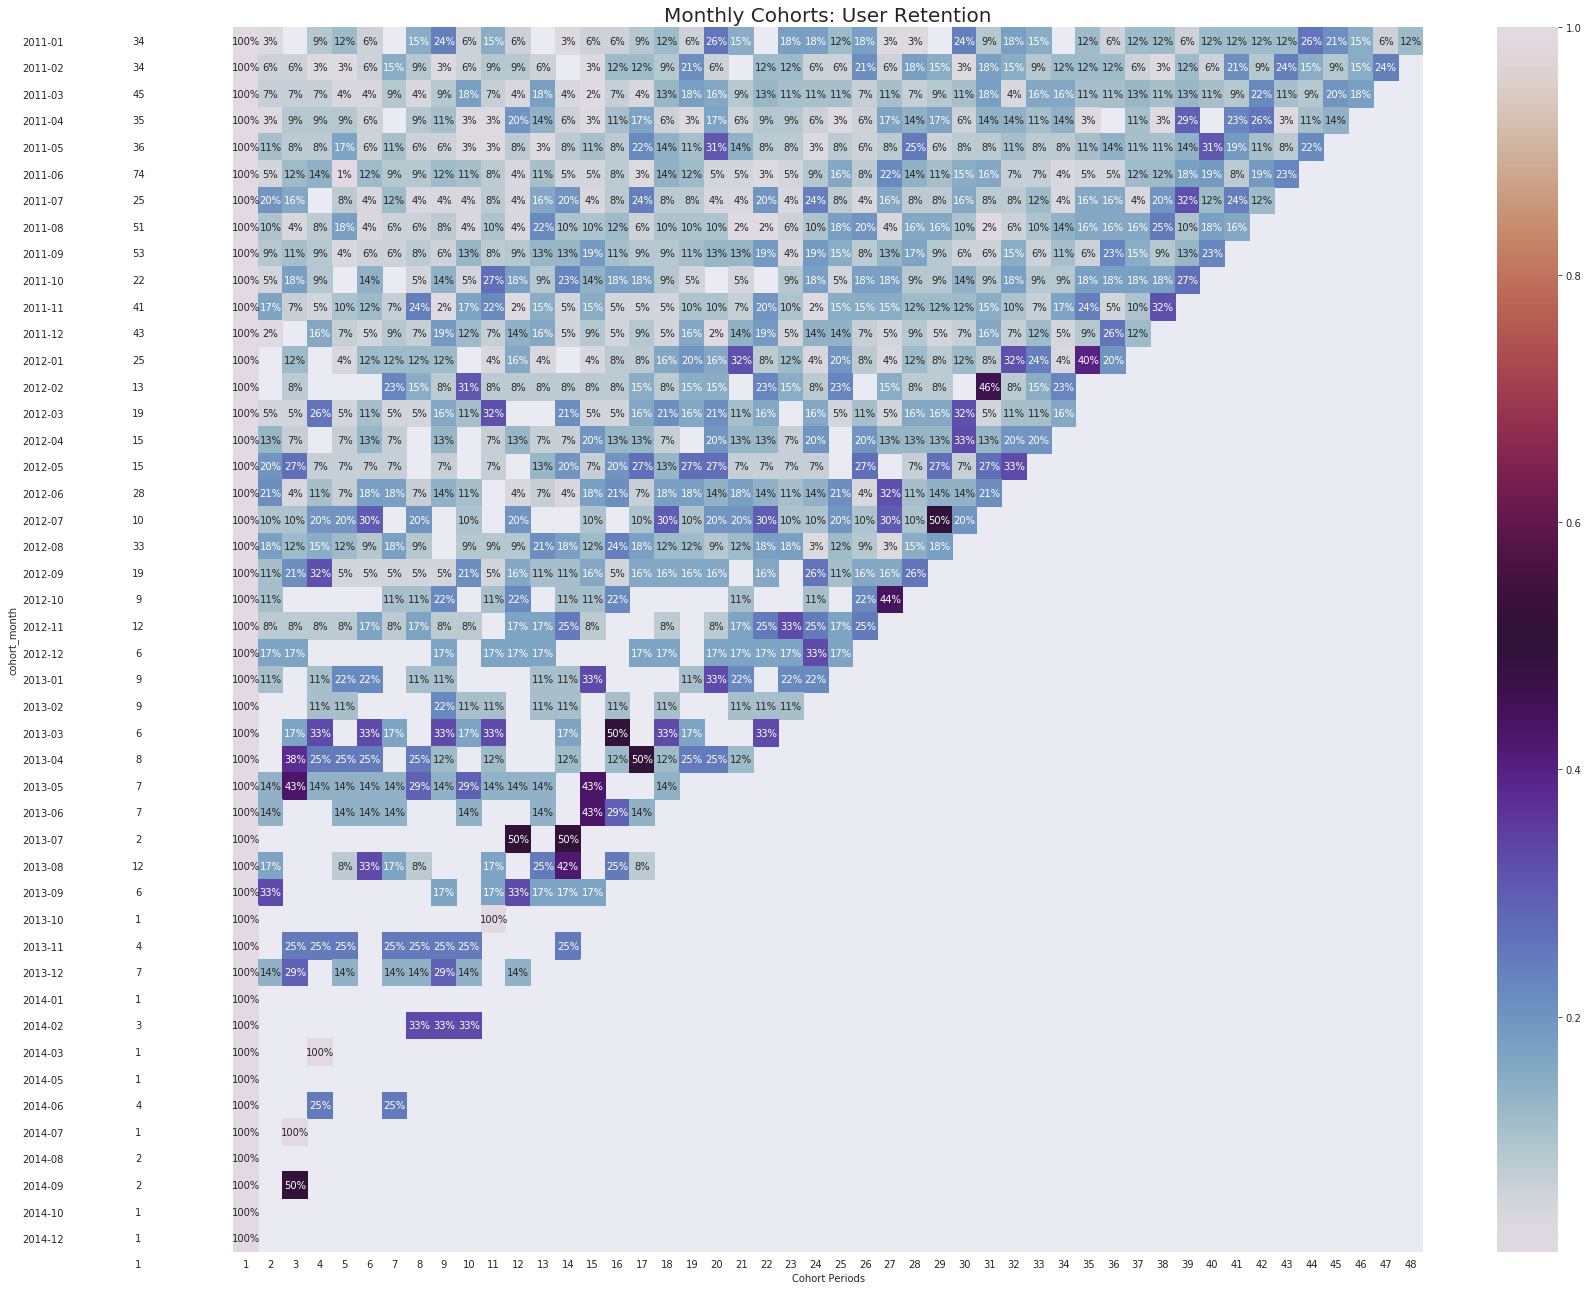

In [39]:
import matplotlib.colors as mcolors

"""
retention over user life time(CULV)-> 
retention over product lifetime|->
"""

with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 2, 
                           figsize=(24, 18), 
                           sharey=True, 
                           gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt=".0%", 
                cmap="twilight", 
                ax=ax[1])
    
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=20)
    ax[1].set(xlabel='Cohort Periods',
              ylabel=" ")

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_sizes).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout() 